In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(filename='/home/saqib/Downloads/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from pylab import rcParams
import pickle

In [4]:
rcParams['figure.figsize'] = 18, 10
sn.set_style('darkgrid')

In [5]:
from fastai import conv_learner
from fastai import dataloader
from fastai import dataset
from fastai import core
from fastai import transforms

## Test Submission File Creation
Helper functions to create a submission. Since some images in the test set are missing, a simple strategy is to fill the missing ones with the majority class.

In [6]:
# Convert class ids (0, 1, 2...) to class names (Abstract, Biker etc)
def classes_to_names(pred_classes, class_names, datapoints):
    matrix = list()
    for i, pclass in enumerate(pred_classes):
        matrix.append([datapoints[i], class_names[pclass]])
    return matrix

In [7]:
# Convert class ids (0, 1, 2...) to class names (Abstract, Biker etc)
# Also append the likelihoods of each class to the end so that they
# can be used for creating new models (stacking, ensembling)
def classes_to_names_with_likelihoods(pred_classes, class_names, datapoints, likelihoods):
    matrix = list()
    for i, pclass in enumerate(pred_classes):
        matrix.append([datapoints[i], class_names[pclass]] + list(likelihoods[i]))
    return matrix

In [8]:
# Create a file for submission. The functions expects log likelihoods as
# predictions. They are converted to likelihoods by using exponentiation
# operation and then predictions are made
def create_submission_single_fill(predictions, class_names, filenames, filler, 
                                  output_filename):
    # Convert log likelihoods to likelihoods
    likelihoods = np.exp(predictions)
    # Take the class with the highest likelihood
    pred_classes = np.argmax(likelihoods, axis=1)
    # Convert class ids to class names 
    matrix = classes_to_names(pred_classes, class_names, filenames)
    mat2 = list(map(lambda x: [x[0][5:], x[1]], matrix))
    # Create a prediction column for each filename (obtained after preprocessing CSVs)
    matrix_df = pd.DataFrame(mat2, columns=['filename', 'prediction'])
    # Load the preprocessed CSV, which contains filenames for matching
    test_df = pd.read_csv('data/Submission_online_fnames.csv')
    # Take a left join on the dataframes to fill in the values predicted
    final = test_df.merge(matrix_df, on='filename', how='left')
    # Fill in the missing ones with the majority class
    final['prediction'] = final['prediction'].fillna('Solid')
    final.to_csv(output_filename, index=False)
    print('Saved to {}'.format(output_filename))

In [9]:
# Same as the function above. Just assumes that instead of log likelihoods,
# It gets likelihoods
def create_submission_single_fill_2(likelihoods, class_names, filenames, filler, 
                                  output_filename, source_csv, is_valid=True):
#     likelihoods = np.exp(predictions)
    pred_classes = np.argmax(likelihoods, axis=1)
    matrix = classes_to_names_with_likelihoods(pred_classes, class_names, filenames, likelihoods)
    if is_valid:
        mat2 = list(map(lambda x: [x[0].split('/')[-1], x[1]] + x[2:], matrix))
    else:
        mat2 = list(map(lambda x: [x[0][5:], x[1]] + x[2:], matrix))
    matrix_df = pd.DataFrame(mat2, columns=['filename', 'prediction'] + list(map(str, range(24))))
    test_df = pd.read_csv(source_csv)
    final = test_df.merge(matrix_df, on='filename', how='left')
    final['prediction'] = final['prediction'].fillna('Solid')
    final.to_csv(output_filename, index=False)
    print('Saved to {}'.format(output_filename))

In [11]:
sz = 224 # Images will be resized to 224 X 224 before using as Neural Net's inputs
path = 'data/images_train/' # Path of training data

In [12]:
# We use Resnet-50 here for our experiments
arch = core.resnet50

In [13]:
## Get a learner object to train the ResNet-50 model
arch = core.resnet50
# Get a Dataset object (which encapsulates a PyTorch data object)
data = dataset.ImageClassifierData.from_paths(path, # data path 
                                              bs=16, # batch size 
                                              tfms=transforms.tfms_from_model(arch, sz) # Images will be transformed accoring to the model
                                             )
# Finally get a convolutional learner object
learner = conv_learner.ConvLearner.pretrained(arch, # Architecture here is Resnet-50
                                              data, # Dataset object 
                                              precompute=True # Use precomputed activations of the pre-trained ResNet-50
                                             )

In [26]:
# Try training the convolutional network with a random learning rate
learner.fit(5e-4, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 21%|██        | 732/3516 [00:08<00:33, 81.97it/s, loss=1.68]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      1.405608   1.22146    0.653995  
    1      1.204695   1.157737   0.665915                      



[1.1577367, 0.6659149484536082]

In [12]:
# Use precomputed activations to determine the optimal learning rate
learner = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)
# This finds the learning rate using the technique in Leslie Smith's cyclical learning rates paper of 2015
lrf = learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 2515/3516 [09:43<03:52,  4.31it/s, loss=6.13]

In [22]:
# Plot the learning rate
learner.sched.plot_lr()

In [25]:
# Plot the learning rate against loss
learner.sched.plot()

In [27]:
# Data augmentation on the images
trans = transforms.tfms_from_model(arch, # Resnet-50
                                   sz, # 224 
                                   aug_tfms=transforms.transforms_side_on, # Performs small rotations, changes in brighness and random horizontal flips 
                                   max_zoom=1.15)

In [28]:
# Get some transformation to see
def get_augs():
    data = conv_learner.ImageClassifierData.from_paths(path, bs=2, 
                                                       tfms=trans, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [29]:
ims = np.stack([get_augs() for i in range(6)])

In [30]:
# Helper function to display the transformed images
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [31]:
plots(ims, figsize=(18, 10), rows=2)

In [32]:
# Get the augmented data
data = conv_learner.ImageClassifierData.from_paths(path, bs=16, tfms=trans)
# Get a new learner object with the augmented dataset for training
learner = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
learner.fit(5e-4, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      1.402774   1.213735   0.658102  
    1      1.270334   1.158992   0.665163                      
    2      1.229112   1.130716   0.671365                      



[1.1307158, 0.6713649055046826]

In [21]:
# Turn off the precomputed activations
learner.precompute = False

In [35]:
# Fit for 3 epochs and a single cycle
learner.fit(5e-4, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.304773   1.131671   0.668707  
    1      1.20694    1.122285   0.668868                     
    2      1.231603   1.118608   0.671365                     



[1.1186079, 0.6713649055046826]

In [38]:
learner.save('resnet-50-1')

In [39]:
# Finetuning and differential rate annealing
learner.unfreeze()

In [40]:
# Use weights increasing in a geometrical progression to train the network
# The earlier layers need less finetuning since they learn to recognize low-level (simpler)
# features. The later layers learn more complex features and need to be finetuned more
# The entire network is divided into three layer groups and each layer group is finetuned
# using the same learning rate.
lrs = np.array([5e-4 / 4.0, 5e-4 / 2.0, 5e-4])

In [41]:
# Train the neural network for three cycles
# cycle_len=1 means reset the the learning rate after every epoch (the learning rate 
# is decresed for every data point using Cosine Annealing)
# cycle_mult=2 means reset the learning rate in a multiple of two epoch (uses
# cycle_len as the base and keeps resetting the learning rate after 1, 2, 4... epochs)
# This is an implementation of Stochastic Gradient Descent with Restarts (SGDR)
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.173728   1.017635   0.698427  
    1      1.068942   0.959236   0.713944                      
    2      0.943297   0.93594    0.716844                      


KeyboardInterrupt: 

In [43]:
learner.fit(lrs, 1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 5/3516 [00:07<1:24:57,  1.45s/it, loss=0.979]

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.967767   0.897903   0.729194  
    1      0.835698   0.879788   0.735852                      
    2      0.830207   0.868823   0.738832                      



[0.86882335, 0.7388316151330766]

In [44]:
learner.save('resnet-50-diff-anneal-1-complete')

## Finetuning the Network Further

In [58]:
# Finetuning and differential rate annealing
learner.unfreeze()

In [45]:
# Try to find a better learning rate for the newly trained network 
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████   | 2486/3516 [31:25<13:01,  1.32it/s, loss=2.94] 

In [47]:
learner.sched.plot()

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1398: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


In [49]:
lrs = np.array([5e-4 / 4.0, 5e-4 / 2.0, 5e-4])
learner.load('resnet-50-diff-anneal-1-complete')

In [50]:
# Train the network for three cycles, each time resetting the learning rate to the
# original after every multiple of 2
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-50-diff-anneal-02')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.870342   0.869673   0.739369  
    1      0.774051   0.870597   0.740201                      
    2      0.763043   0.858937   0.74651                       
    3      0.801722   0.886691   0.74302                       
    4      0.75879    0.868098   0.75094                       
    5      0.639454   0.864971   0.749919                      
    6      0.671376   0.864234   0.751933                      



[0.8642337, 0.7519329896907216]

## Finetuning v2. Use less epochs. Change the transformations

In [18]:
# Change the zoom level to get slightly more different augmentations
trans = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)

In [19]:
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, test_name='test')

In [22]:
# Load the latest cycle weights to finetune the network further
learner.load('resnet-50-diff-anneal-02_cyc_2')

In [23]:
# Freeze all the layers to determine the learning rate
learner.freeze()

In [24]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/3516 [00:00<?, ?it/s]


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 70%|███████   | 2477/3516 [41:58<17:36,  1.02s/it, loss=2.16]   


In [ ]:
allDone()

In [33]:
learner.sched.plot_lr()

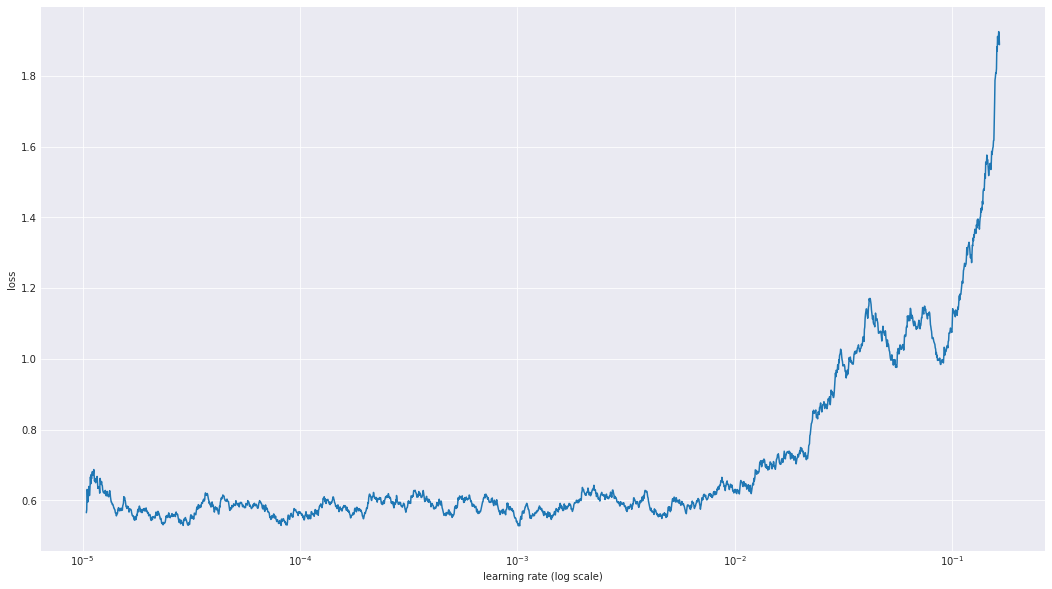

In [25]:
plt.clf()
learner.sched.plot()

In [37]:
learner.sched.plot_loss()

In [38]:
# We will use 1e-4 as the new learning rate as indicated (in the invisible graph)

In [47]:
type(learner)

fastai.conv_learner.ConvLearner

In [27]:
# Train the network using differential rate annealing
# and the new learning rates
lrs = np.array([0.25e-4, 0.5e-4, 1e-4])

In [28]:
learner.set_data(test_data)

In [29]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, 
            cycle_save_name='resnet-50-diff-anneal-1_lr-1e-4')
allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.57024    0.850563   0.753112  
    1      0.570698   0.851195   0.752145                      
    2      0.591311   0.854297   0.753873                      
    3      0.574922   0.857061   0.754247                      
    4      0.581452   0.858603   0.753075                      
    5      0.558653   0.854829   0.753793                      
    6      0.568887   0.858721   0.753273                      



## Training The Network on Smaller Images
Training on smaller images will regularize the network. Hence, we now train on smaller images

In [10]:
sz = 224 # But before making the images smaller, we need to load the pretrained weights
         # for images of size 224 X 224. 
arch = core.resnet50
trans = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)

In [11]:
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')

In [12]:
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-50-diff-anneal-1_lr-1e-4_cyc_0')

In [13]:
# Now, train the network on 128 X 128 sized images.
trans = transforms.tfms_from_model(arch, 128, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')

In [17]:
first = next(iter(test_data_2.aug_dl))

In [14]:
learner.set_data(test_data)

Everything from this point is a re-iteration of the previous steps.
1. Train the last layer of the network by freezing all other layers
2. Unfreeze the network and and use differential rate annealing (Cosine Annealing + SGDR)
3. Train the network again and again until it overfits, then change the input image size, as a regularization step and repeat

In [18]:
learner.freeze()

In [39]:
lrs = np.array([0.25e-4, 0.5e-4, 1e-4])
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-50-128pix')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/879 [00:00<?, ?it/s]                     


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.035371   1.155809   0.673641  
    1      1.019409   1.13429    0.675941                    
    2      1.003922   1.131567   0.676585                    
 42%|████▏     | 366/879 [13:41<19:11,  2.24s/it, loss=1.02] 


KeyboardInterrupt: 

In [19]:
learner.load('resnet-50-128pix_cyc_1')

In [20]:
lrs = np.array([0.25e-4, 0.5e-4, 1e-4])
learner.fit(lrs, n_cycle=1, cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.012042   1.122465   0.678357  
    1      0.974809   1.112085   0.679968                    
    2      0.97802    1.109367   0.680934                    
    3      0.982904   1.108017   0.681337                    



[1.1080173, 0.6813371038621234]

In [21]:
learner.save('resnet-50-128pix_cyc_2')

In [23]:
learner.load('resnet-50-128pix_cyc_2')
learner.unfreeze()
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
learner.fit(lrs, 2, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-50-128pix_unfrozen')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/879 [00:00<?, ?it/s]                     


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      1.000017   1.099373   0.686617  
    1      0.970841   1.062078   0.694444                    
    2      0.960035   1.052782   0.696861                    



[1.0527817, 0.6968606815663809]

In [15]:
learner.load('resnet-50-128pix_unfrozen_cyc_1')
learner.unfreeze()
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
learner.fit(lrs, 1, cycle_len=4, cycle_save_name='resnet-50-128pix_unfrozen-02')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.933382   1.035386   0.701356  
    1      0.91237    1.022916   0.70501                     
    2      0.901652   1.019675   0.704527                    
    3      0.896993   1.018989   0.703868                    



[1.018989, 0.703867769195247]

## Train on Large Images

In [9]:
sz = 224
arch = core.resnet50
trans = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, test_name='test')
learner = conv_learner.ConvLearner.pretrained(arch, test_data)

In [10]:
arch = core.resnet50
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, test_name='test')

In [11]:
learner.set_data(test_data)

In [18]:
learner.freeze()

In [19]:
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-50-diff-anneal-299pix')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.855949   0.897352   0.734187  
    1      0.79593    0.883155   0.739986                      
    2      0.770443   0.88316    0.738134                      
    3      0.824212   0.879081   0.741436                      
    4      0.833409   0.875838   0.74208                       
    5      0.797079   0.87602    0.740389                      
    6      0.780228   0.872053   0.742241                      



[0.8720528, 0.7422411941644764]

In [9]:
arch = core.resnet50
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, test_name='test')
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-50-diff-anneal-299pix_cyc_2')
learner.unfreeze()
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
# learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-34-diff-anneal-299pix-unfrozen')

In [ ]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-50-diff-anneal-299pix-unfrozen')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.711496   0.832666   0.753436  
    1      0.659374   0.829185   0.755906                      
    2      0.676466   0.826436   0.756229                      
    3      0.706725   0.829312   0.757598                      
 86%|████████▋ | 3041/3516 [42:04<06:34,  1.20it/s, loss=0.67] 

In [11]:
learner.load('resnet-50-diff-anneal-299pix-unfrozen_cyc_1')
learner.fit(lrs, 1, cycle_len=4, 
            cycle_save_name='resnet-50-diff-anneal-299pix-unfrozen-02')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                        
    0      0.66929    0.825792   0.758349  
    1      0.631351   0.824534   0.758698                        
    2      0.582126   0.824631   0.758537                        
    3      0.659952   0.829202   0.757329                        



[0.82920194, 0.7573292525773195]

In [ ]:
learner.unfreeze()
lrs = np.array([1e-4 / 16.0, 1e-4 / 4.0, 1e-4 / 2.0])
learner.load('resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0')
learner.fit(lrs, 3, cycle_len=1, cycle_mult= 2,
            cycle_save_name='resnet-50-diff-anneal-299pix-unfrozen-03')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.656283   0.831097   0.757437  
    1      0.646101   0.834653   0.758457                      
 64%|██████▍   | 2249/3516 [33:14<18:43,  1.13it/s, loss=0.549]

In [ ]:
learner.unfreeze()
lrs = np.array([1e-4 / 16.0, 1e-4 / 4.0, 1e-4 / 2.0])
learner.load('resnet-50-diff-anneal-299pix-unfrozen-03_cyc_0')
learner.fit(lrs, 2, cycle_len=2, cycle_mult= 2,
            cycle_save_name='resnet-50-diff-anneal-299pix-unfrozen-04')

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.693586   0.867153   0.75545   
    1      0.563479   0.866005   0.754403                      
    2      0.580241   0.865734   0.75451                       
    3      0.579482   0.865866   0.756739                      
 75%|███████▌  | 2645/3516 [29:00<09:33,  1.52it/s, loss=0.609]

## ResNet-50 Best Model Submission

In [14]:
# Once we are satisfied with training our network, we load the
# one with the minimal validation loss
arch = core.resnet50
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, val_name='train')
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0')

In [14]:
predictions = learner.predict_dl(test_data.test_dl)

In [15]:
create_submission_single_fill(predictions, test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0.csv')

Saved to resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0.csv


In [16]:
# Perform test time augmentations to increase the prediction accuracy
tta_test = learner.TTA(n_aug=16, is_test=True)

In [17]:
allDone()

In [18]:
logits, y = tta_test

In [19]:
create_submission_single_fill(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0-tta16.csv')

Saved to resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0-tta16.csv


In [20]:
tta_test = learner.TTA(n_aug=32, is_test=True)
allDone()

In [21]:
logits, y = tta_test
create_submission_single_fill(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0-tta32.csv')

Saved to resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0-tta32.csv


In [24]:
likes = np.mean(np.exp(logits), 0)

In [25]:
likes.shape

(14712, 24)

## Create Training Augmentations
This was an attempt to use TTA (Test Time Augmentation) to generate more features, that could be fed to another model (Tree or Linear or even another network) to improve the accuracy (Model Stacking). 

In [15]:
arch = core.resnet50
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, val_name='train')
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-50-diff-anneal-299pix-unfrozen-02_cyc_0')

In [11]:
arch = core.resnet50
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, val_name='valid', test_name='test')

In [17]:
trn_tta = learner.TTA(n_aug=16, is_test=False)

In [20]:
import pickle
pickle.dump(trn_tta, open('train_tta.pkl', 'wb'))

In [10]:
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, val_name='valid', test_name='test')
learner.set_data(test_data)

NameError: name 'trans' is not defined

In [22]:
val_tta = learner.TTA(n_aug=16, is_test=False)

In [23]:
pickle.dump(val_tta, open('val_tta.pkl', 'wb'))

In [24]:
test_tta = learner.TTA(n_aug=16, is_test=True)

In [ ]:
pickle.dump(test_tta, open('test_tta.pkl'))

## Create New Feature Files for Improving Models
New feature files are created for model stacking. An XGBoost Classifier is trained on it

In [12]:
trn_tta = pickle.load(open('train_tta.pkl', 'rb'))

In [13]:
logits, y = trn_tta

In [14]:
logits.shape

(20, 56247, 24)

In [16]:
tmp = logits[0]

In [20]:
trn_mean = np.mean(np.exp(logits), 0)

In [35]:
create_submission_single_fill_2(trn_mean, test_data.classes, test_data.val_ds.fnames,
                                    'Solid', 'data/myntra_train_augmented.csv', 'data/myntra_train_dataset_with_fnames.csv')

Saved to data/myntra_train_augmented.csv


In [38]:
val_tta = pickle.load(open('val_tta.pkl', 'rb'))
logits, y = val_tta
val_mean = np.mean(np.exp(logits), 0)
create_submission_single_fill_2(val_mean, test_data.classes, test_data.val_ds.fnames,
                                    'Solid', 'data/myntra_val_augmented.csv', 'data/myntra_train_dataset_with_fnames.csv')

Saved to data/myntra_val_augmented.csv


In [13]:
test_tta = pickle.load(open('test_tta.pkl', 'rb'))
logits, y = test_tta
test_mean = np.mean(np.exp(logits), 0)
create_submission_single_fill_2(test_mean, test_data.classes, test_data.test_ds.fnames,
                                    'Solid', 'data/myntra_test_augmented.csv', 'data/Submission_online_fnames.csv', is_valid=False)

Saved to data/myntra_test_augmented.csv
